In [2]:
from dotenv import load_dotenv
load_dotenv()

True

# StateGraph 상태 만들기

In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph

# 정보를 주고받을수 있는 그래프. 각 노드에서 다음 노드로 전달되는 상태를 저장한다.
# 타입을 지정해서 dictionary형태로 저장한는 TypedDict, State는 그래프다.
class State(TypedDict):
    counter: int
    alphabet: list[str]

# State Graph에 정해진 틀을 넣어준다.
graph_builder = StateGraph(State)

In [14]:
# 그래프 만들기
from typing import Annotated # 어떤값을 지정할 떄 해당값에 메타데이터를 넣어주는 역할.
from typing_extensions import TypedDict #위에서 TypedDict를 가져오는것과 차이는 없음.

from langgraph.graph import StateGraph, START, END
import operator
# 그래프 클래스 정의
# State를 TypedDict로 선언해서 정보를 주고받을 틀을 만들건데, 특성에는 int를 받는 counter와 string형태의 list를 받는 alphabet이 있다.
class State(TypedDict):
    counter : int
    alphabet : list[str]

# 노드함수 정의
# 입력값으로 우리가 정의한 State를 받아야 한다. 입력값이 들어오면 counter에 1씩더하고, alphabet은 Hello라는 스트링으로 리스트에 지정한다.
def node_a(state: State):
    state['counter'] += 1
    state['alphabet'] = ["Hello"]
    return state

graph_builder = StateGraph(State)

# chatbot이라는 노드를 만드는데, 이것은 node_a를 실행시킨다.
graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 실행 가능한 객체로 만들기 위해 compile()이라는 함수를 만들어야 한다.
graph = graph_builder.compile()


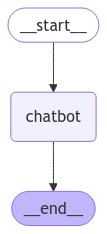

In [15]:
# 시각화
from IPython.display import Image, display
# 머메이드라는 다이어그램을 그려주는 툴을 활용해서 png파일로 쥬피터 셀에서 볼 수 있다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional.
    pass

In [16]:
# 초기 상태 정의. state의 시작을 정의한다.
initial_state = {
    "counter": 0,
    "alphabet" : []
}

state = initial_state

# state를 3번 돌려서 실행한다.
for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


# Annotated

특성을 업데이트. Annotated를 통해서 list가 어떤 행동을 할수 있는지에 대해서 metadata를 추가. 

In [17]:
# 알파벳이라는 특성을 업데이트. Annotated를 통해서 list가 어떤 행동을 할수 있는지에 대해서 metadata를 추가. 
# operator.add는 단순히 더해주는 역할. list에 있는 string이 계속 더해진다. 이것은 챗봇의 메모리를 더해준다고 생각하면 된다. 이 메모리는 그래프 내에서만 기억한다.

from typing_extensions import TypedDict #위에서 TypedDict를 가져오는것과 차이는 없음.
from typing import Annotated # 어떤값을 지정할 떄 해당값에 메타데이터를 넣어주는 역할.

from langgraph.graph import StateGraph, START, END
import operator

# 그래프 정의
class State(TypedDict):
    counter: int
    alphabet: Annotated[list[str], operator.add]

# 노듸 정의
def node_a(state:State):
    state["counter"] += 1
    state["alphabet"] = ["Hello"]
    return state

# 엣지로 서로 이어주기.
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot") # graph_builder.set_entry_point("chatbot")
graph_builder.add_edge("chatbot", END) # graph_builder.set_finish_point("chatnot")

graph = graph_builder.compile()        

In [18]:
#초기상태 정의
initial_state = {
    "counter": 0,
    "alphabet": []
}
state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello', 'Hello']}
{'counter': 3, 'alphabet': ['Hello', 'Hello', 'Hello']}


# Message를 담은 StateGraph 만들기

state에 messages라는 유일한 키값을 넣어준다. 이것도 list형태로 제공을 받을건데, add_messages라는 metadata를 가질것이라는 annotated를 선언한다.

In [31]:
from typing import Annotated # 알파벳이라는 특성을 업데이트. Annotated를 통해서 list가 어떤 행동을 할수 있는지에 대해서 metadata를 추가. 
from langchain_openai import ChatOpenAI

from typing import TypedDict

from langgraph.graph import StateGraph 
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages] # list를 업데이트할때, add_messages를 통해 누적해서 메세지를 쌓아나간다.

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

# 입력값은 State 출력값은 "messages"라는 키값에 llm이 주어진 messages를 입력해서 invoke한 실행 결과다.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# add_edge(START, "chatbot"), add_edge('chatbot', END)와 같음

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

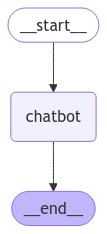

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [33]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values(): #event안에는 state가 있다.
            print("Assistant: ", value["messages"][-1].content) # 가장 최신의 content를 assistant에 넣고 print하겠다.

Assistant:  Hello! How can I assist you today?
Assistant:  안녕하세요! 어떻게 도와드릴까요?
Goodbye!


In [41]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph
# MessagesState는 메세지만 STATE로 받겠다는 뜻이다.
graph_builder = StateGraph(MessagesState)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


In [42]:
while True:
    user_input = input("User" )
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: 안녕하세요! 어떻게 도와드릴까요?
Goodbye!


In [45]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

# MessagesState특성과 counter의 특성을 둘다 가지고 있는 State
class State(MessagesState):
    counter: int

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    state["counter"] = state.get("counter", 0) + 1 #counter값이 없으면0, 아니면 있는값에 +1
    return {
        "messages" : [llm.invoke(state["messages"])],
        "counter": state["counter"]
    }

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

In [46]:
from langchain_core.messages import HumanMessage
# 초기상태 설정
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "counter" : 0
}

# 그래프 실행
result = graph.invoke(initial_state)

print(f"Final state: {result}")

Final state: {'messages': [HumanMessage(content='Hello!', id='23dca1ac-2bf1-4f05-90b8-ab9dc8c97f31'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 9, 'total_tokens': 18, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-1c807c30-b9f8-4465-b61c-1c3d611c0493-0', usage_metadata={'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18})], 'counter': 1}


In [54]:
state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(f"counter: {state['counter']}")
    print(f"Last message: {state['messages'][-1].content}")
    print("---")

counter: 1
Last message: Hello! How can I assist you today?
---
counter: 2
Last message: Hello! How can I assist you today?
---
counter: 3
Last message: Hello! How can I assist you today?
---
